## Visualizing Fire Scars through False Color and Social Dimension Analysis
Author: Joaquin Sandoval 
More content within this analysis can be found in its GitHub repository: https://github.com/sandovaljoaquin/eaton-palisades-fire-analysis


![](img/fires.png)
Overview of Palisades and Eaton Wildfires in a satellite image provided by MaxarTechnologies.


## About 

The Eaton and Palisades Fires occured in Janurary 2025 in Los Angeles County and were some of the most devastating in California history. These two fires scorched a combined amount of 37,469 acres and destroyed or damaged an estimated 18,298 structures (Cal Fire). The following analyses will enable visualization of the fire scar left behind using remote sensing data and investigate if minority groups were disproportionately affected. 

### Highlights : 
- Fire perimeter boundary data import and exploration. 
- Landsat data import and exploration as an `xarray.Dataset`.
- Restoring geospatial information to an `xarray.Dataset`.
- Plotting a True-Color Image and False Color Image with fire perimeter boundaries. 
- Cropping census tract data from EJI to the fire boundaries.
- Plotting estimated minority % of cenus tracts within each fire boundary.

### About the data  

1. **`eaton_boundary`** – dissolved fire perimeter/boundary for Eaton Fire (01/21/2025).  
2. **`palisades_boundary`** – dissolved fire perimeter/boundary for Palisades Fire (01/21/2025).  
3. **`landsat`** – simplified collection of bands (red, green, blue, near‑infrared, shortwave infrared) from Landsat Collection 2 Level‑2 atmospherically corrected surface‑reflected data (Landsat 8). Clipped to Los Angeles County to include both fire perimeters.  
4. **`eji_california`** – 2024 Environmental Justice Index data for California (geodatabase format).  

### References  

- NIFC FIRIS – CA Perimeters: <https://services1.arcgis.com/jUJYIo9tSA7EHvfZ/ArcGIS/rest/services/CA_Perimeters_NIFC_FIRIS_public_view/FeatureServer>  

- Microsoft Planetary Computer – Landsat C2 L2: <https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2>  

- CDC & ATSDR – Environmental Justice Index: <https://atsdr.cdc.gov/place-health/php/eji/eji-data-download.html>

## Begin Visualization 

Import necessary packages.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr 
import contextily as ctx

## Fire Perimeter Data Exploration

The analysis begins by loading the perimeter shapefiles for the Eaton and Palisades fires. Once imported, each dataset is examined to uncover its spatial reference details.

In [2]:
# Import perimeter of eaton fire 
fp = os.path.join("data", "Eaton_Perimeter_20250121", "Eaton_Perimeter_20250121.shp")
eaton_boundary = gpd.read_file(fp)

# Import perimeter of palisades fire 
fp = os.path.join("data", "Palisades_Perimeter_20250121", "Palisades_Perimeter_20250121.shp")
palisades_boundary = gpd.read_file(fp)

In [3]:
# Examine CRS details of `eaton_boundary`
print(f"CRS of eaton_boundary: {eaton_boundary.crs}")
print('Datum', eaton_boundary.crs.datum)
print('Is geographic?', eaton_boundary.crs.is_geographic)
print('Is projected?', eaton_boundary.crs.is_projected)

CRS of eaton_boundary: EPSG:3857
Datum World Geodetic System 1984 ensemble
Is geographic? False
Is projected? True


In [4]:
# Examine CRS details of `palisades_boundary`
print(f"CRS of palisades_boundary: {palisades_boundary.crs}")
print('Datum', palisades_boundary.crs.datum)
print('Is geographic?', palisades_boundary.crs.is_geographic)
print('Is projected?', palisades_boundary.crs.is_projected)

CRS of palisades_boundary: EPSG:3857
Datum World Geodetic System 1984 ensemble
Is geographic? False
Is projected? True


## NetCDF Data Import and Exploration

The Landsat data is loaded as an `xarray.Dataset`. It contains reflectance‑band variables organized along the dimensions (time, band, latitude, longitude), with coordinates that define the spatial grid and timestamps.

In [5]:
# Import Landsat data using `xr.open_dataset()`
landsat = xr.open_dataset('data/landsat8-2025-02-23-palisades-eaton.nc')
landsat.head()

<xarray.Dataset> Size: 596B
Dimensions:      (y: 5, x: 5)
Coordinates:
  * y            (y) float64 40B 3.799e+06 3.799e+06 ... 3.799e+06 3.799e+06
  * x            (x) float64 40B 3.344e+05 3.344e+05 ... 3.345e+05 3.345e+05
    time         datetime64[ns] 8B ...
Data variables:
    red          (y, x) float32 100B ...
    green        (y, x) float32 100B ...
    blue         (y, x) float32 100B ...
    nir08        (y, x) float32 100B ...
    swir22       (y, x) float32 100B ...
    spatial_ref  int64 8B ...

The dataset unfolds as a **5 × 5 grid** with dimensions **y = 5** and **x = 5**. Its coordinates are:

- **x, y** – the grid axes defining each cell’s position.  
- **time** – the temporal axis for the observations.  
- **spatial_ref** – a placeholder for spatial reference information (empty for now, to be resolved later in the notebook).

The data variables capture the spectral content:

- **red, green, blue** – the visible bands.  
- **nir08** – the near‑infrared band.  
- **swir22** – the short‑wave infrared band.

## Restoring Geospatial Information

The next notebook section restores the geospatial information of the `xarray.Dataset`. It obtains the CRS from the `spatial_ref.crs_wkt` attribute and adds it back to the dataset.

In [6]:
# Using rio.crs to print CRS of the dataset
print(landsat.rio.crs)

None


In [7]:
# Geospatial information for dataset stored in `spatial_ref`
# Print CRS of `landsat` by accessing `spatial_ref.crs_wkt` attribute
print(landsat.spatial_ref.crs_wkt)

PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]


In [8]:
# Recover geospatial information by using `rio.write_crs()` and the spatial reference information 
landsat = landsat.rio.write_crs(landsat.spatial_ref.crs_wkt)

# Print the  CRS of updated `landsat` dataset 
print(landsat.rio.crs)

EPSG:32611


## True Color Image 

Now that the Landsat data carries its geospatial metadata, it can be visualized. A true‑color image can be plotted by extracting the red, green, and blue bands from the `xarray.Dataset` and rendering them with `plot.imshow()`. The red band records reflectance in the visible red range (0.64-0.67µm), the green band records reflectance around the visible green range (0.53-0.59µm), and the blue band records reflectance in the visible blue range (0.45-0.51 µm). Together, these three bands reproduce an image as the human eye would see it.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


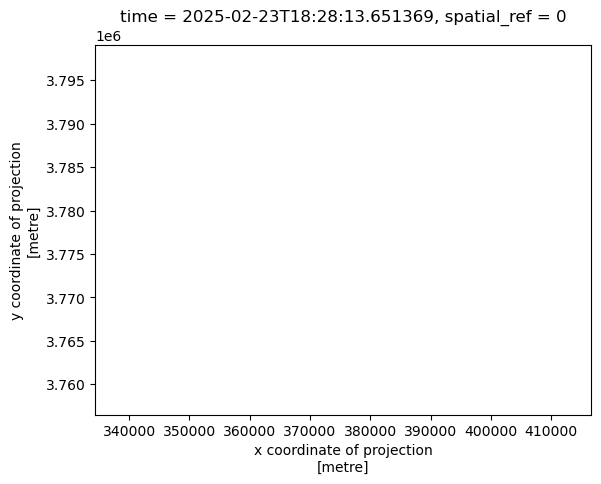

In [9]:
# Select the red, green, and blue variables of the xarray.Dataset holding the Landsat data

landsat[['red','green','blue']].to_array().plot.imshow()

The plot appears blank because the current settings don’t handle outliers and missing data. By adjusting the `robust` argument in `plot.imshow()` and cleaning any `nan` values from the `xarray.Dataset`, the image can be rendered correctly. Each band should be inspected for `nan`s, removed where present, and then the true‑color composite can be displayed.

/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


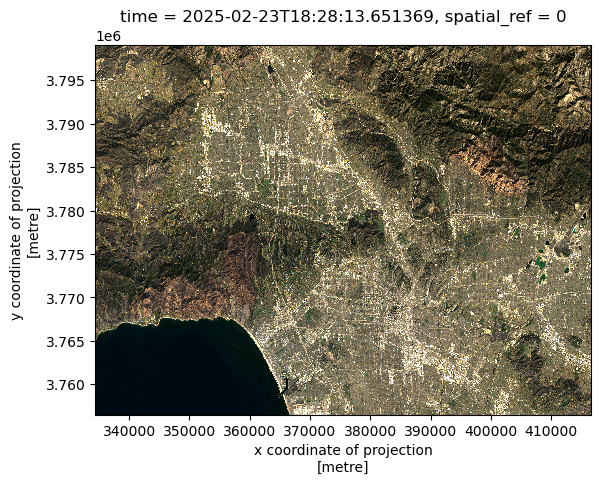

In [10]:
# Adjust the scale used for plotting the bands to get a true color image
landsat[['red','green','blue']].to_array().plot.imshow(robust = True)

In [11]:
# Check if each band has nan values

# Red band 
print(bool(np.isnan(landsat['red']).any()))

# Green band 
print(bool(np.isnan(landsat['green']).any()))

# Blue band 
print(bool(np.isnan(landsat['blue']).any()))


False
True
True


The analysis shows `nan`s in the green and blue bands. After filtering out those missing values, the cleaned data can be used to plot a finalized true‑color image.

In [12]:
# Using .fillna() to substitute the nan values with 0 
landsat['green'] = landsat['green'].fillna(0)
landsat['blue'] = landsat['blue'].fillna(0)

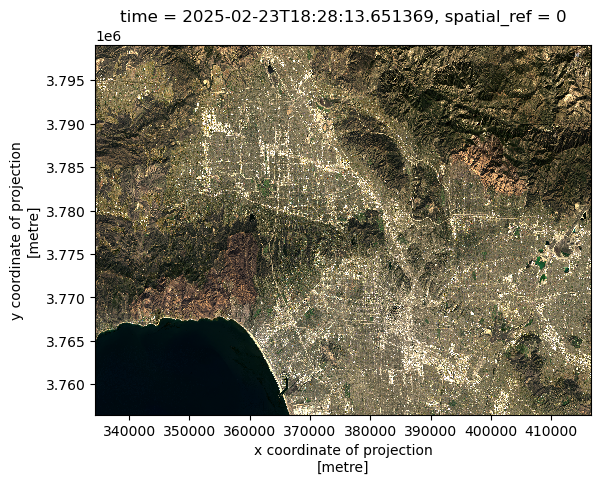

In [13]:
# Plot new true color image without warnings 
landsat[['red','green','blue']].to_array().plot.imshow(robust = True)

##  False Color Image

The false‑color composite can be created by extracting the short‑wave infrared, near‑infrared, and red bands, in that sequence, from the Landsat dataset and displaying them together.

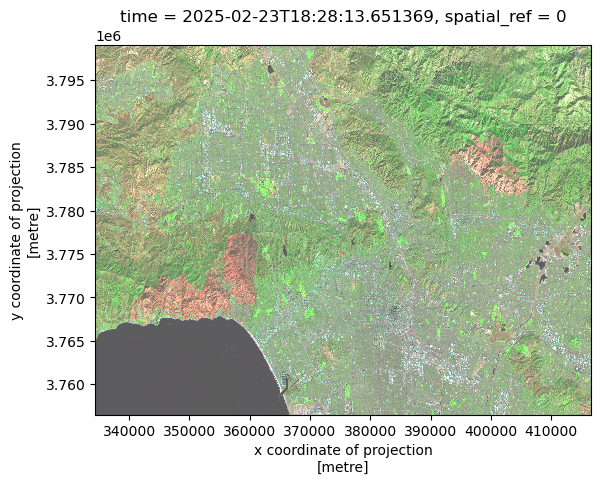

In [14]:
# Plot false color image with short-wave infared, near-infared, and red variables 
landsat[['swir22','nir08','red']].to_array().plot.imshow(vmin = 0, 
                                                       vmax = 20000, 
                                                       robust = True)

## Fire Perimeters and False-color Image

The false‑color composite will displayed with the `eaton_boundary` and `palisades_boundary` layered on top. Because the Landsat dataset uses a different CRS, the boundary geometries are reprojected to match the Landsat CRS before plotting.

In [15]:
# Convert  to CRS of both fire boundaries to landsat CRS

eaton_boundary = eaton_boundary.to_crs(landsat.rio.crs)
palisades_boundary = palisades_boundary.to_crs(landsat.rio.crs)


(334395.0, 416655.0, 3756525.0, 3799065.0)

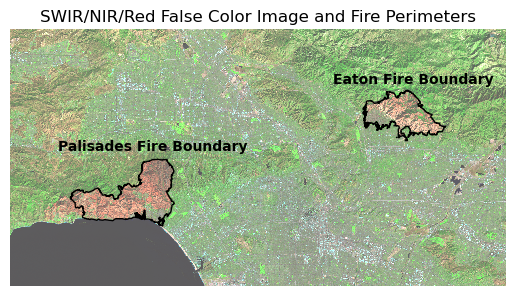

In [16]:
# Shortwave infrared/near-infrared/red false color image together with both fire perimeters
fig, ax = plt.subplots()

landsat[['swir22','nir08','red']].to_array().plot.imshow(vmin = 0, 
                                                       vmax = 20000, 
                                                       robust = True)
                                                      

eaton_boundary.plot(ax=ax,         
                 edgecolor='black',
                  color = 'none',
                 linewidth=1) 

palisades_boundary.plot(ax=ax,        
                edgecolor = 'black',
                 color = 'none',
                linewidth= 1) 
                
plt.figtext(x = .63, 
            y = .65,
            s ="Eaton Fire Boundary", 
            weight = 'bold')

plt.figtext(x = .2, 
            y = .51,
            s ="Palisades Fire Boundary", 
            weight = 'bold')
ax.set_title("SWIR/NIR/Red False Color Image and Fire Perimeters")
ax.axis('off')

The false‑color image is created by selecting the short‑wave infrared, near‑infrared, and red bands from the Landsat data and plotting them. The fire‑perimeter boundaries are overlaid on the resulting scar, highlighting the area revealed by the composite. False‑color imagery blends visible and non‑visible wavelengths, enhancing contrasts in land cover that are difficult to discern in true‑color images. In this case, burned zones appear orange, whereas unburned areas or vegetation show up as green or neutral tones.

## Social Dimensions Analysis with the EJI Dataset

In [17]:
# Import perimeter of eaton fire 
fp = os.path.join("data", "Eaton_Perimeter_20250121", "Eaton_Perimeter_20250121.shp")
eaton_boundary = gpd.read_file(fp)

# Import perimeter of palisades fire 
fp = os.path.join("data", "Palisades_Perimeter_20250121", "Palisades_Perimeter_20250121.shp")
palisades_boundary = gpd.read_file(fp)

In [18]:
# Import CA EJI gdb 
fp = os.path.join("data", "EJI_2024_California", "EJI_2024_California.gdb")
eji_california = gpd.read_file(fp)

## Visualize Extent of Fires over Los Angeles County 

The Palisades and Eaton fire perimeters will be displayed on top of an OpenStreetMap base, revealing the portions of Los Angeles County that were impacted. Since both boundaries share the same CRS, no reprojection is required.

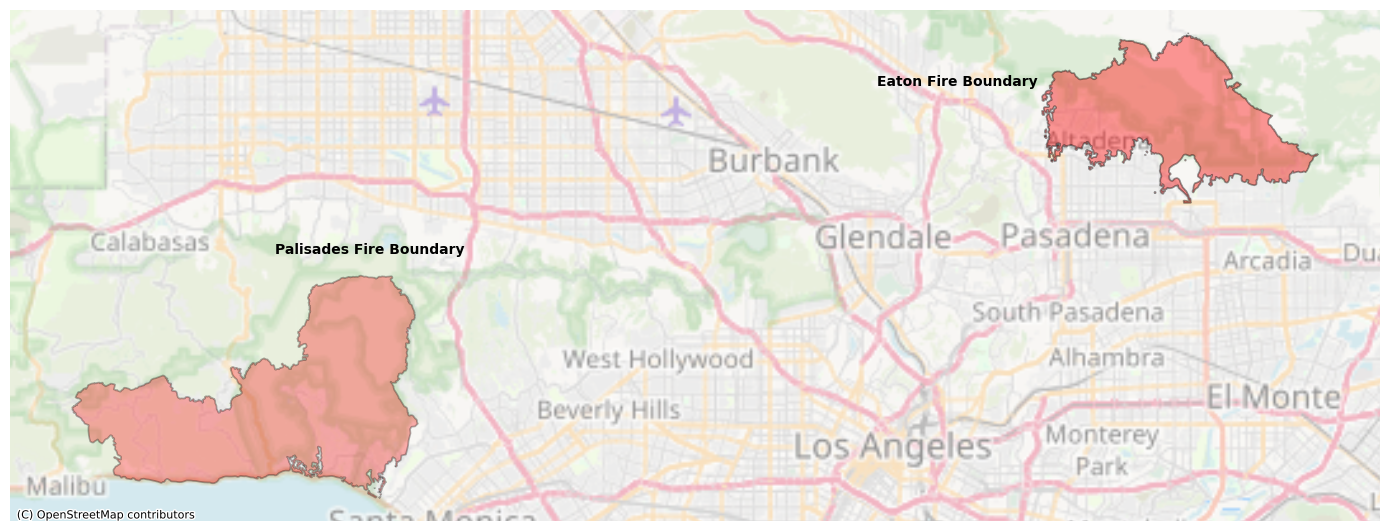

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

# Plot both fire perimeters 

palisades_boundary.plot(ax=ax,        
                edgecolor = 'black',
                color = 'red',          # Update color
                linewidth= 1.25, 
                alpha = .3)             # Fill transparency

eaton_boundary.plot(ax=ax,         
                 edgecolor='black',
                 color = 'red',
                 linewidth=1.25, 
                 alpha = .4)

# Add text annotations adjacent to fire perimeters 
plt.figtext(x = .63, 
            y = .65,
            s ="Eaton Fire Boundary", 
            weight = 'bold')

plt.figtext(x = .2, 
            y = .51,
            s ="Palisades Fire Boundary", 
            weight = 'bold')

# Add basemap using contextily

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, 
                alpha = .5)
# Turn off axis 
ax.axis('off')

plt.tight_layout()
plt.show()

The plotted map displays the Palisades and Eaton fire perimeters over an OpenStreetMap base of Los Angeles and its neighboring cities. The Palisades Fire burned the area between Malibu, Calabasas, and Santa Monica, while the Eaton Fire occurred in Altadena, just north of Pasadena.

## Process EJI data 

The fire perimeters will be overlaid on the census tracts that fell within each boundary, allowing for an analysis using the EJI dataset. By focusing on the `E_MINRTY` variable, it is possible to assess whether minority groups were disproportionately impacted. As always, the CRS of all interacting datasets have to match. 

In [20]:
# Convert the CRS of eji_california to the CRS of palisades_boundary 

eji_california = eji_california.to_crs(palisades_boundary.crs)

Census tracts intersecting each fire perimeter are extracted by clipping the tract layer to the size of the fire boundary using `gpd.clip()`.

In [21]:
# Clip the shape of eji_california to that of the each fire boundary

eji_palisades_clipped = gpd.clip(eji_california, palisades_boundary)

eji_eaton_clipped = gpd.clip(eji_california, eaton_boundary)

`eji_palisades_clipped` and `eji_eaton_clipped` now contain the census tracts that fall within the boundaries of the Palisades and Eaton fires, respectively.

## Plot estimated minority % of fire‑boundary census tracts

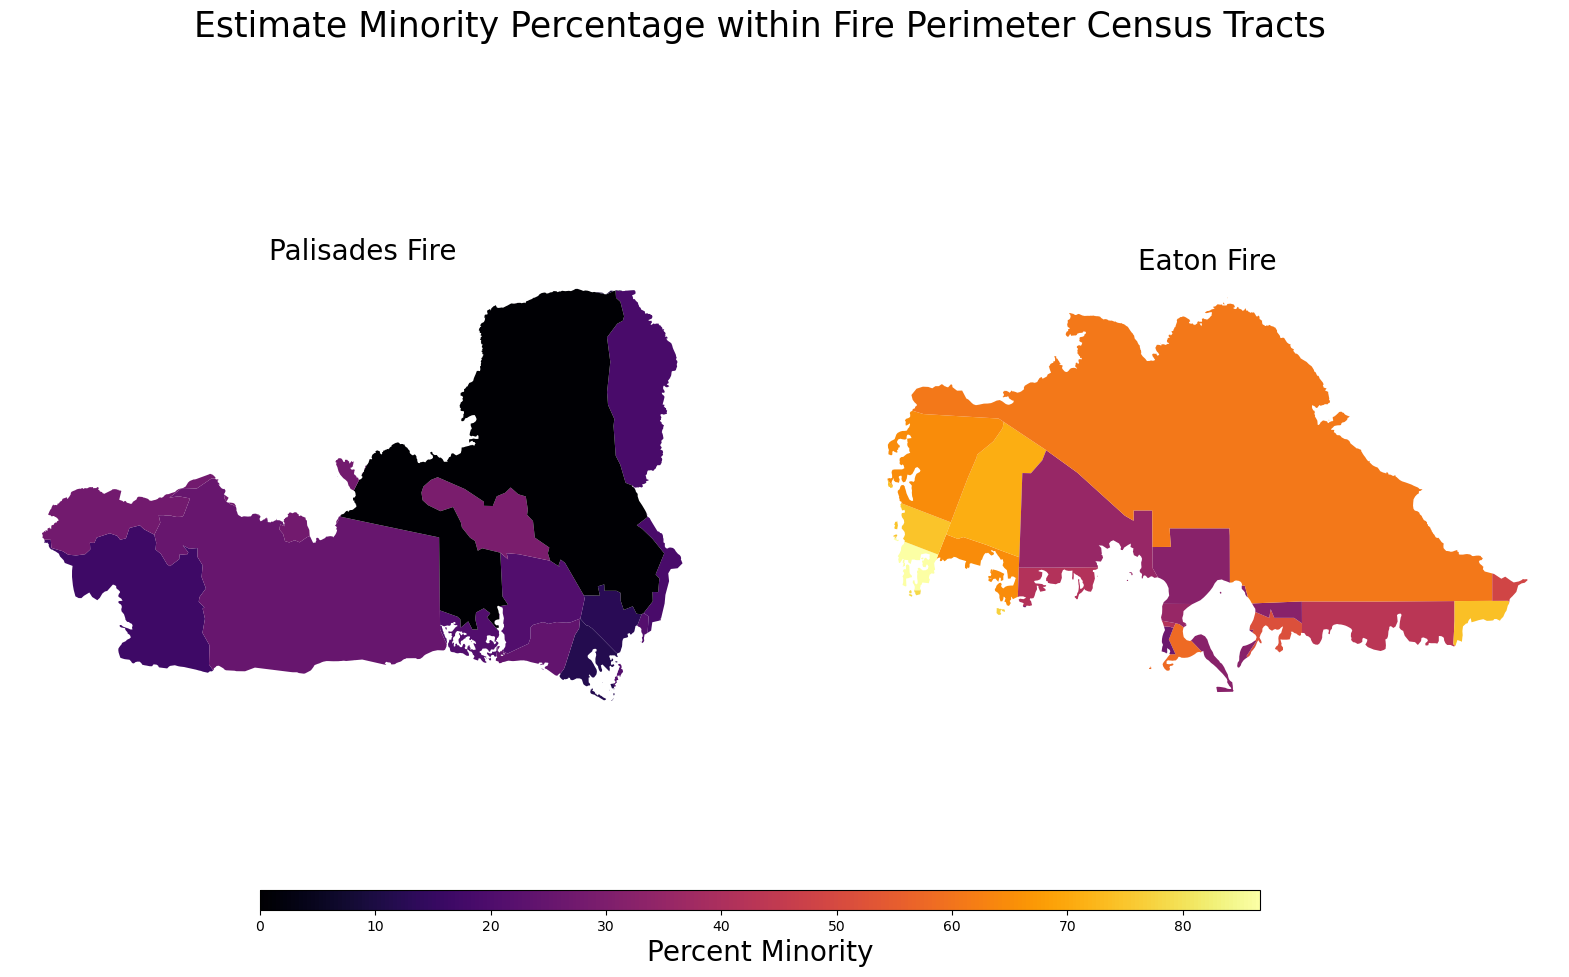

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Estimate minority % variable 
eji_variable = 'E_MINRTY'

# Find common min/max for legend range
vmin = min(eji_palisades_clipped[eji_variable].min(), eji_eaton_clipped[eji_variable].min())
vmax = max(eji_palisades_clipped[eji_variable].max(), eji_eaton_clipped[eji_variable].max())

# Plot census tracts within Palisades perimeter
eji_palisades_clipped.plot(
    column= eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax1,
    cmap = 'inferno'
)
ax1.set_title('Palisades Fire', 
              fontsize = 20)
ax1.axis('off')

# Plot census tracts within Eaton perimeter
eji_eaton_clipped.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax2,
    cmap= 'inferno'
)
ax2.set_title('Eaton Fire', 
              fontsize = 20)
ax2.axis('off')

# Add overall title
fig.suptitle('Estimate Minority Percentage within Fire Perimeter Census Tracts', 
             fontsize = 25)

# Add shared colorbar at the bottom
sm = plt.cm.ScalarMappable( norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap = 'inferno')
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

cbar.set_label('Percent Minority', fontsize = 20)

plt.show()

This image shows two choropleth maps comparing the racial/ethnic minority percentage within the boundaries of the Palisades Fire (left) and the Eaton Fire (right).

Palisades Fire area: Most tracts are in the lowest percent-minority range (very dark colors near black and purple), indicating a predominantly non-minority population.

Eaton Fire area: Census tracts show much higher minority percentages (yellow, orange, red), indicating a predominantly minority population across most of the fire zone.

Overall, the visualization highlights a strong demographic contrast between the two fire-affected regions. 